## 1. Dependencies/Data Read

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


sns.set(style="whitegrid")
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 100
plt.style.use('ggplot')
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [2]:
df=pd.DataFrame(pd.read_csv("Kickstarter.csv"))
for i in range(1,10):
    df=df.append(pd.read_csv("Kickstarter00" + str(i) + ".csv"))
for i in range(11,49):
    df=df.append(pd.read_csv("Kickstarter0" + str(i) + ".csv"))
df=df.reset_index(drop=True)

## 2. Data Cleaning

In [3]:
df.head()

,backers_count,blurb,category,converted_pledged_amount,country,created_at,creator,currency,currency_symbol,currency_trailing_code,current_currency,deadline,disable_communication,fx_rate,goal,id,is_starrable,launched_at,name,photo,pledged,profile,slug,source_url,spotlight,staff_pick,state,state_changed_at,static_usd_rate,urls,usd_pledged,usd_type,location,friends,is_backing,is_starred,permissions
0,80,I will be an artist-in-residence at Elsewhere ...,"{""urls"":{""web"":{""discover"":""http://www.kicksta...",3596,US,1325980505,"{""urls"":{""web"":{""user"":""https://www.kickstarte...",USD,$,True,USD,1334866560,False,1.00,2800.00,1562040083,False,1332969260,Elsewhere Studios artist-in-residency program!,"{""small"":""https://ksr-ugc.imgix.net/assets/011...",3596.00,"{""background_image_opacity"":0.8,""should_show_f...",elsewhere-studios-artist-in-residency-program,https://www.kickstarter.com/discover/categorie...,True,False,successful,1334866560,1.00,"{""web"":{""project"":""https://www.kickstarter.com...",3596.00,domestic,"{""country"":""US"",""urls"":{""web"":{""discover"":""htt...",NaN,NaN,NaN,NaN
1,47,We are looking to bring a Visiting Sculptor fr...,"{""urls"":{""web"":{""discover"":""http://www.kicksta...",4117,US,1330727362,"{""urls"":{""web"":{""user"":""https://www.kickstarte...",USD,$,True,USD,1334959598,False,1.00,3900.00,1437561817,False,1332972398,Martin Luther King Jr. Sculpture on Campus!,"{""small"":""https://ksr-ugc.imgix.net/assets/011...",4117.00,"{""background_image_opacity"":0.8,""should_show_f...",martin-luther-king-jr-sculpture-on-campus,https://www.kickstarter.com/discover/categorie...,True,False,successful,1334959598,1.00,"{""web"":{""project"":""https://www.kickstarter.com...",4117.00,domestic,"{""country"":""US"",""urls"":{""web"":{""discover"":""htt...",NaN,NaN,NaN,NaN
2,80,Surrealistic oil paintings capturing the metam...,"{""urls"":{""web"":{""discover"":""http://www.kicksta...",3125,US,1332598567,"{""urls"":{""web"":{""user"":""https://www.kickstarte...",USD,$,True,USD,1334635140,False,1.00,750.00,574125813,False,1332975679,EMERGENCE: Surreal Oil Paintings by J.J. Long,"{""small"":""https://ksr-ugc.imgix.net/assets/011...",3125.00,"{""background_image_opacity"":0.8,""should_show_f...",emergence-surreal-oil-paintings-by-jj-long,https://www.kickstarter.com/discover/categorie...,True,False,successful,1334635143,1.00,"{""web"":{""project"":""https://www.kickstarter.com...",3125.00,domestic,"{""country"":""US"",""urls"":{""web"":{""discover"":""htt...",NaN,NaN,NaN,NaN
3,82,1000 Artists is a public art-making installati...,"{""urls"":{""web"":{""discover"":""http://www.kicksta...",4586,US,1330926084,"{""urls"":{""web"":{""user"":""https://www.kickstarte...",USD,$,True,USD,1336440145,False,1.00,4500.00,858990141,False,1332984145,1000 Artists: Presidential Inauguration 2013,"{""small"":""https://ksr-ugc.imgix.net/assets/011...",4586.00,"{""background_image_opacity"":0.8,""should_show_f...",1000-artists-presidential-inauguration-2013,https://www.kickstarter.com/discover/categorie...,True,False,successful,1336440145,1.00,"{""web"":{""project"":""https://www.kickstarter.com...",4586.00,domestic,"{""country"":""US"",""urls"":{""web"":{""discover"":""htt...",NaN,NaN,NaN,NaN
4,31,P.M.A.F.T.W. my upcoming solo show June 2012 a...,"{""urls"":{""web"":{""discover"":""http://www.kicksta...",1036,US,1332476607,"{""urls"":{""web"":{""user"":""https://www.kickstarte...",USD,$,True,USD,1333421843,False,1.00,1000.00,566704999,False,1332989843,P.M.A.F.T.W.,"{""small"":""https://ksr-ugc.imgix.net/assets/011...",1036.00,"{""background_image_opacity"":0.8,""should_show_f...",pmaftw,https://www.kickstarter.com/discover/categorie...,True,False,successful,1333421843,1.00,"{""web"":{""project"":""https://www.kickstarter.com...",1036.00,domestic,"{""country"":""US"",""urls"":{""web"":{""discover"":""htt...",NaN,NaN,NaN,NaN


In [4]:
df.shape

(191573, 37)

In [5]:
df.isnull().sum()

backers_count                    0
blurb                           11
category                         0
converted_pledged_amount         0
country                          0
created_at                       0
creator                          0
currency                         0
currency_symbol                  0
currency_trailing_code           0
current_currency                 0
deadline                         0
disable_communication            0
fx_rate                          0
goal                             0
id                               0
is_starrable                     0
launched_at                      0
name                             1
photo                            0
pledged                          0
profile                          0
slug                             0
source_url                       0
spotlight                        0
staff_pick                       0
state                            0
state_changed_at                 0
static_usd_rate     

In [6]:
df=df.drop(df[df.state=='live'].index).reset_index(drop=True)

df.location=df.location.fillna('short_name":"Other')

cat, sub, loc, duration=[],[],[],[]

for i in range(0,len(df)):
    sub.append(re.search('(?<="name":")\w+(.[a-zA-Z]+)(.[a-zA-Z]+)?', df.category.iloc[i]).group())
    cat.append(re.search('(?<="slug":")\w+', df.category.iloc[i]).group().capitalize())
    loc.append(re.search('(?<=short_name":")(....)?[-]?([a-zA-Z]+)?\s?[-]?([a-zA-Z]+)?', df.location.iloc[i]).group())
    duration.append(abs((datetime.strptime(datetime.fromtimestamp(df.deadline[i]).strftime('%Y-%m-%d'),'%Y-%m-%d') 
                 - datetime.strptime(datetime.fromtimestamp(df.launched_at[i]).strftime('%Y-%m-%d'),'%Y-%m-%d'))).days)
    
df['category'], df['subcategory'], df['location'], df['duration'] = cat, sub, loc, duration

In [7]:
df=df[['backers_count', 'category', 'country', 'disable_communication', 'goal', 'staff_pick',
       'state', 'usd_pledged', 'location','subcategory', 'duration']]

In [8]:
df.isnull().sum()

backers_count            0
category                 0
country                  0
disable_communication    0
goal                     0
staff_pick               0
state                    0
usd_pledged              0
location                 0
subcategory              0
duration                 0
dtype: int64

In [9]:
df.state.unique()

array(['successful', 'canceled', 'failed', 'suspended'], dtype=object)

In [10]:
df.state=list(map(lambda x: x.replace('canceled', 'failed') , df.state))
df.state=list(map(lambda x: x.replace('suspended', 'failed') , df.state))

In [11]:
df.head()

,backers_count,category,country,disable_communication,goal,staff_pick,state,usd_pledged,location,subcategory,duration
0,80,Art,US,False,2800.00,False,successful,3596.00,Paonia,Mixed Media,22
1,47,Art,US,False,3900.00,False,successful,4117.00,Bakersfield,Art,23
2,80,Art,US,False,750.00,False,successful,3125.00,Lowell,Painting,19
3,82,Art,US,False,4500.00,False,successful,4586.00,Washington,Public Art,40
4,31,Art,US,False,1000.00,False,successful,1036.00,Portland,Painting,5


# 3. Data Exploration

In [12]:
df.groupby('state').state.count()

state
failed         81521
successful    103474
Name: state, dtype: int64

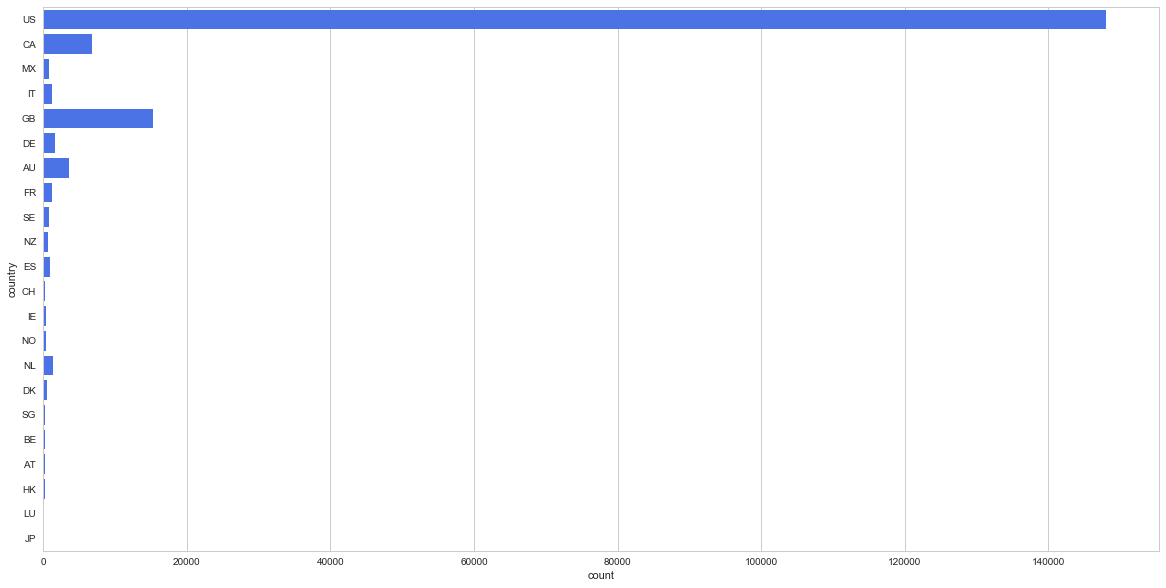

In [13]:
plt.figure(figsize=(20,10))
sns.set(style="whitegrid")
sns.countplot(y="country", data=df, color='#3366ff')

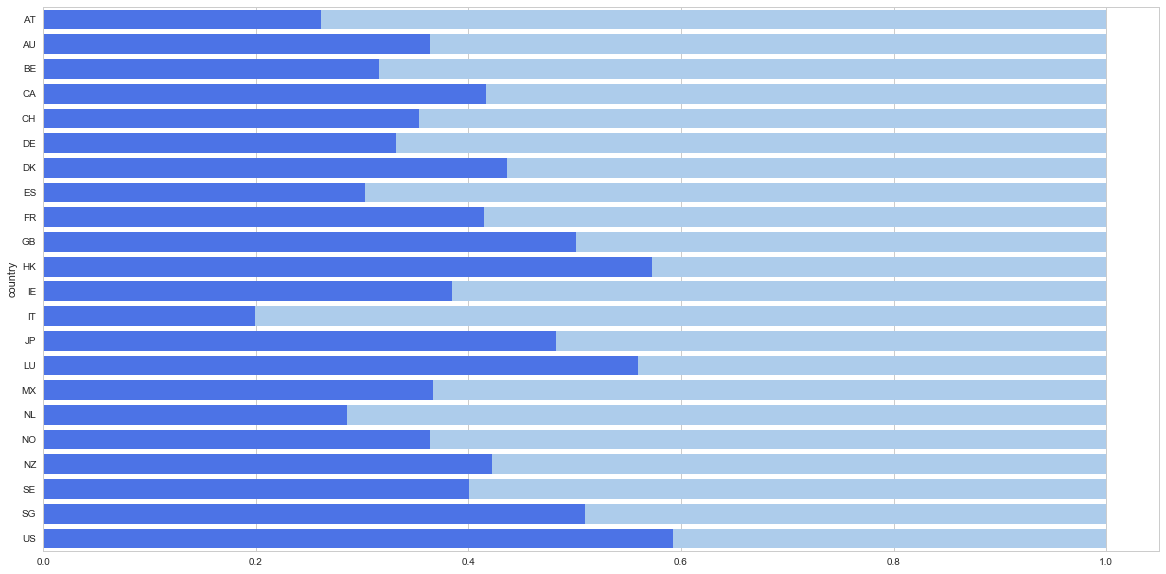

In [14]:
countries=df.groupby(['country', 'state']).count()['goal']
countries=countries[countries.index.get_level_values('state').isin(['successful', 'failed'])]
plt.figure(figsize=(20,10))
sns.barplot(y=countries.index.get_level_values('country').unique(),x=[1 for i in range(1,len(list(countries)),2)],color='#a3ccf5', orient="h")
sns.barplot(y=countries.index.get_level_values('country').unique(),x=[countries[i]/(countries[i-1]+countries[i]) for i in range(1,len(list(countries)),2)],color='#3366ff',orient="h")

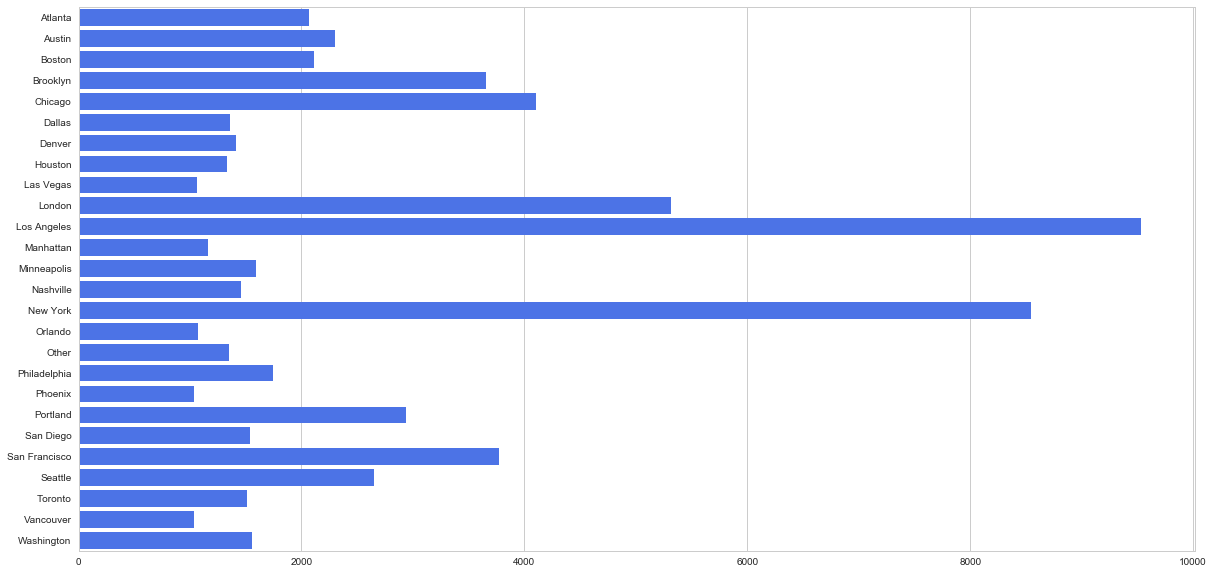

In [15]:
locn=list(df.groupby('location').location.count()[df.groupby('location').location.count()>1000].index)
locc=list(df.groupby('location').location.count()[df.groupby('location').location.count()>1000])
plt.figure(figsize=(20,10))
sns.barplot(y=locn,x=locc,color='#3366ff',orient="h")

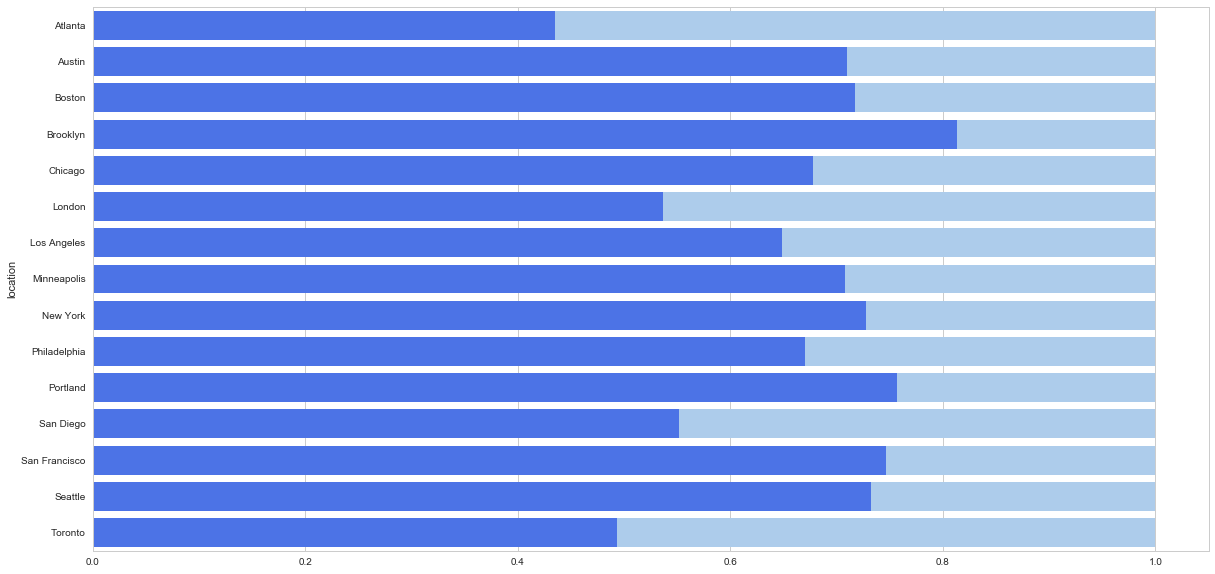

In [16]:
cts=df.groupby(['location', 'state']).count()['goal']
cts=cts[cts.index.get_level_values('state').isin(['successful', 'failed'])]
cts=cts[cts.index.get_level_values('location').isin(['New York', 'London', 'Los Angeles', 'Chicago', 
                                                       'San Francisco','Brooklyn','Portland', 'Seattle', 
                                                       'Austin', 'Boston', 'Atlanta', 'Philadelphia',
                                                       'Minneapolis','San Diego', 'Toronto'])]
plt.figure(figsize=(20,10))
sns.barplot(y=cts.index.get_level_values('location').unique(),x=[1 for i in range(1,len(list(cts)),2)],color='#a3ccf5',orient="h")
sns.barplot(y=cts.index.get_level_values('location').unique(),x=[cts[i]/(cts[i-1]+cts[i]) for i in range(1,len(list(cts)),2)],color='#3366ff',orient="h")

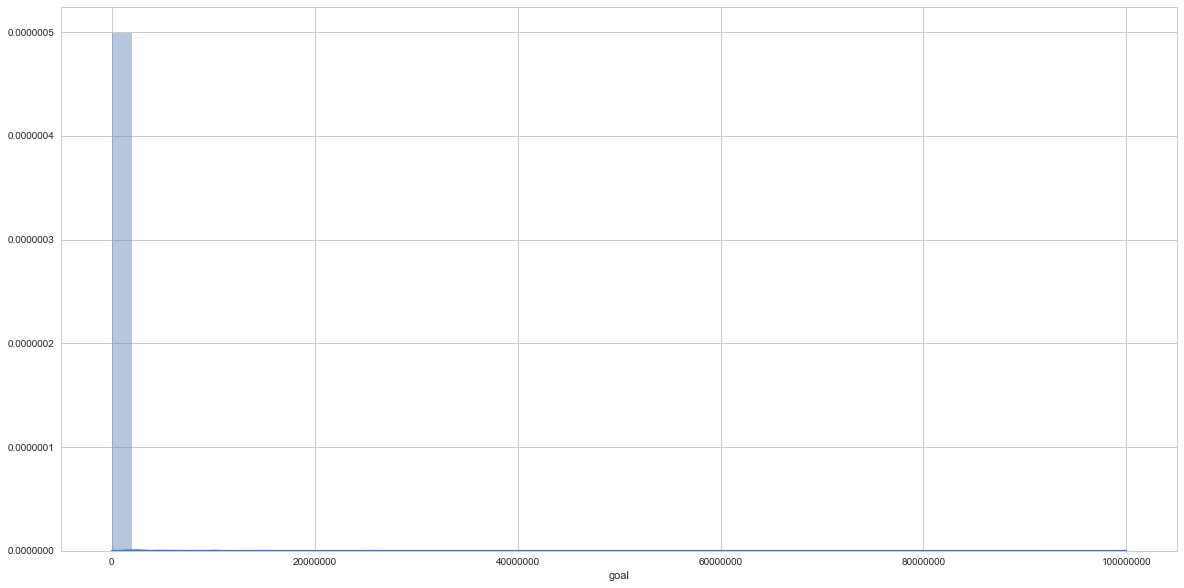

In [17]:
plt.figure(figsize=(20,10))
sns.distplot(df.goal, bins=50)
plt.ticklabel_format(style='plain', axis='both')

In [18]:
df.goal.describe()

count      184995.00
mean        47418.49
std       1232303.32
min             0.01
25%          1500.00
50%          5000.00
75%         12650.00
max     100000000.00
Name: goal, dtype: float64

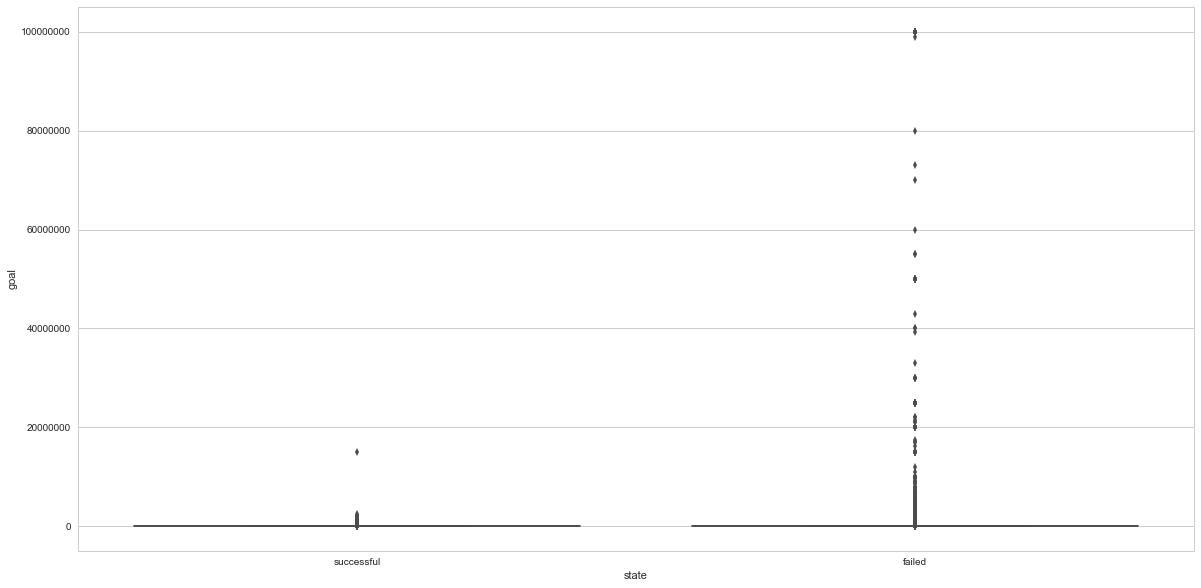

In [19]:
plt.figure(figsize=(20,10))
sns.boxplot(y='goal',x='state', data=df, color='b')
plt.ticklabel_format(style='plain', axis='y')

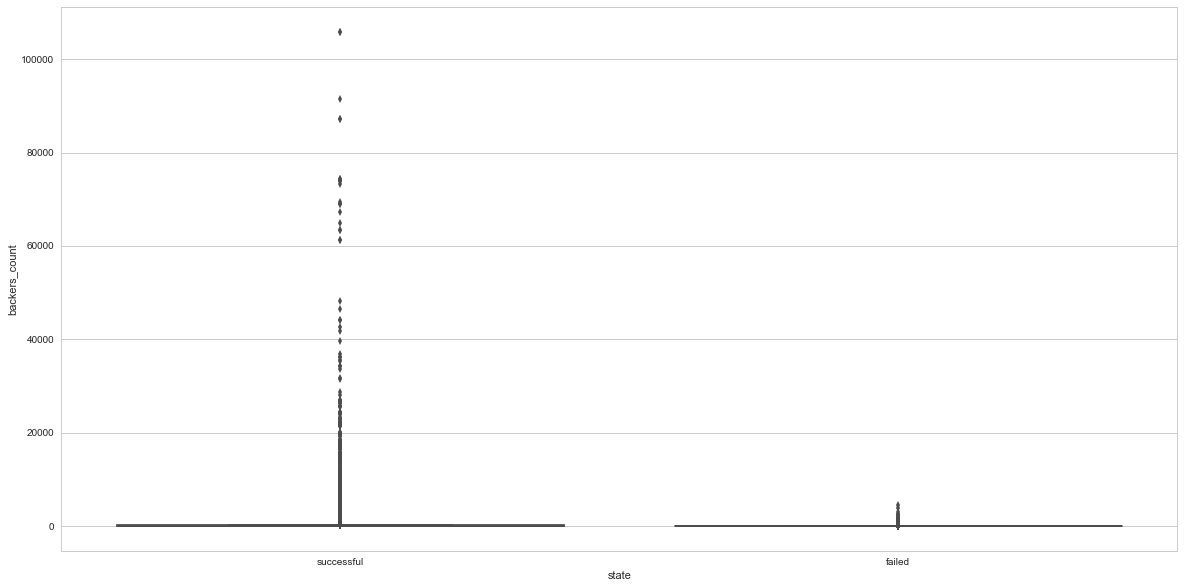

In [20]:
plt.figure(figsize=(20,10))
sns.boxplot(y='backers_count',x='state', data=df, color='b')
plt.ticklabel_format(style='plain', axis='y')

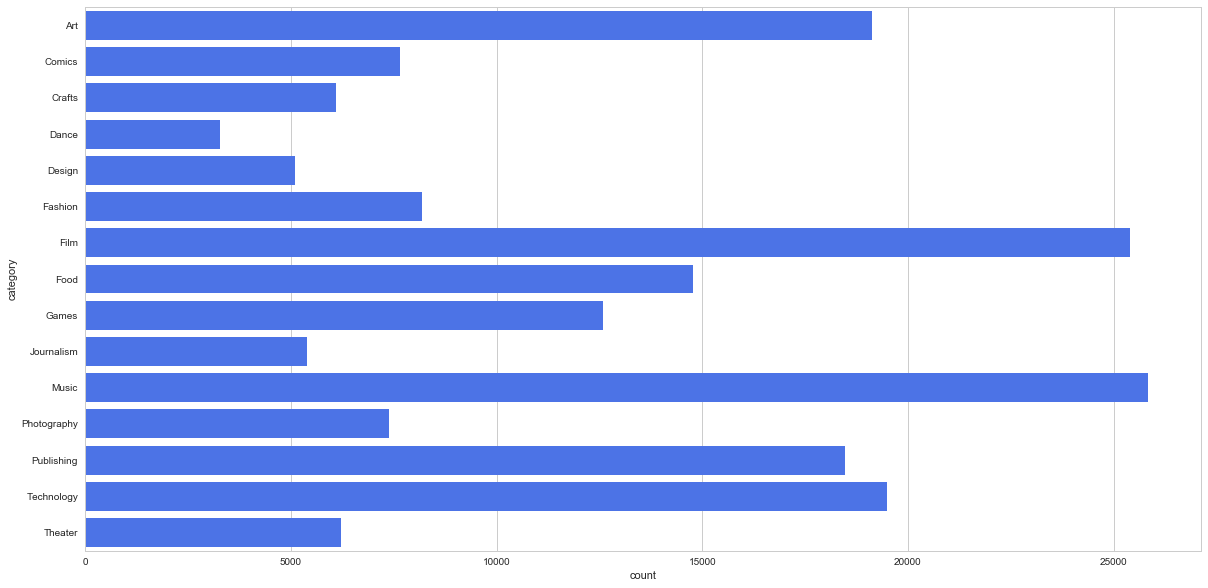

In [21]:
plt.figure(figsize=(20,10))
sns.set(style="whitegrid")
sns.countplot(y="category", data=df, color='#3366ff')

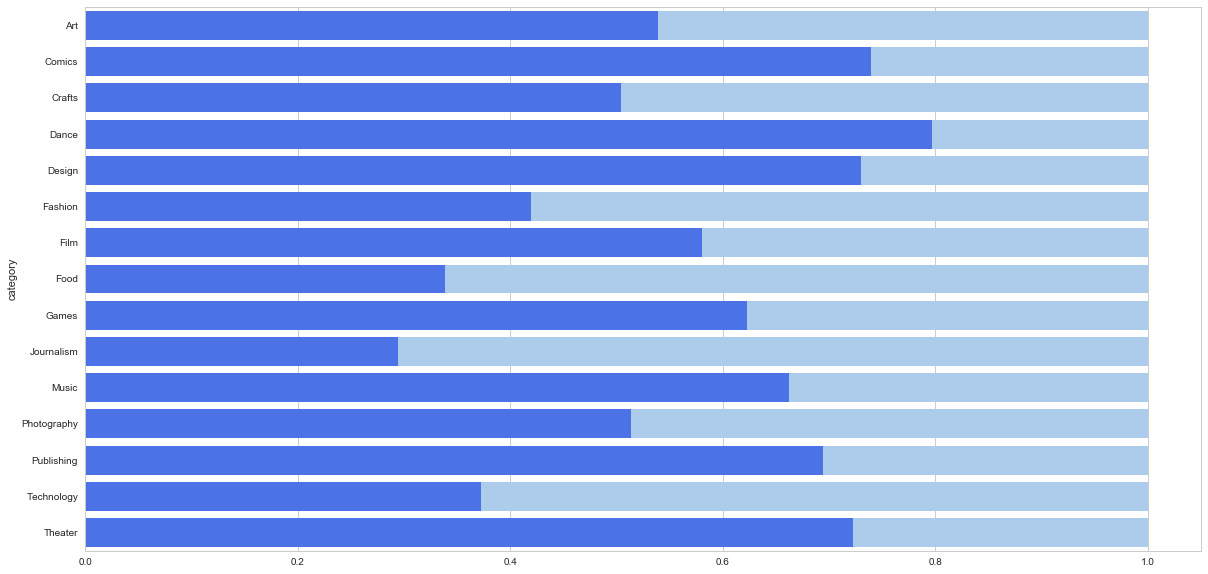

In [22]:
categories=df.groupby(['category', 'state']).count()['goal']
categories=categories[categories.index.get_level_values('state').isin(['successful', 'failed'])]

plt.figure(figsize=(20,10))
sns.barplot(y=categories.index.get_level_values('category').unique(),x=[1 for i in range(1,len(list(categories)),2)],color='#a3ccf5', orient="h")
sns.barplot(y=categories.index.get_level_values('category').unique(),x=[categories[i]/(categories[i-1]+categories[i]) for i in range(1,len(list(categories)),2)],color='#3366ff',orient="h")

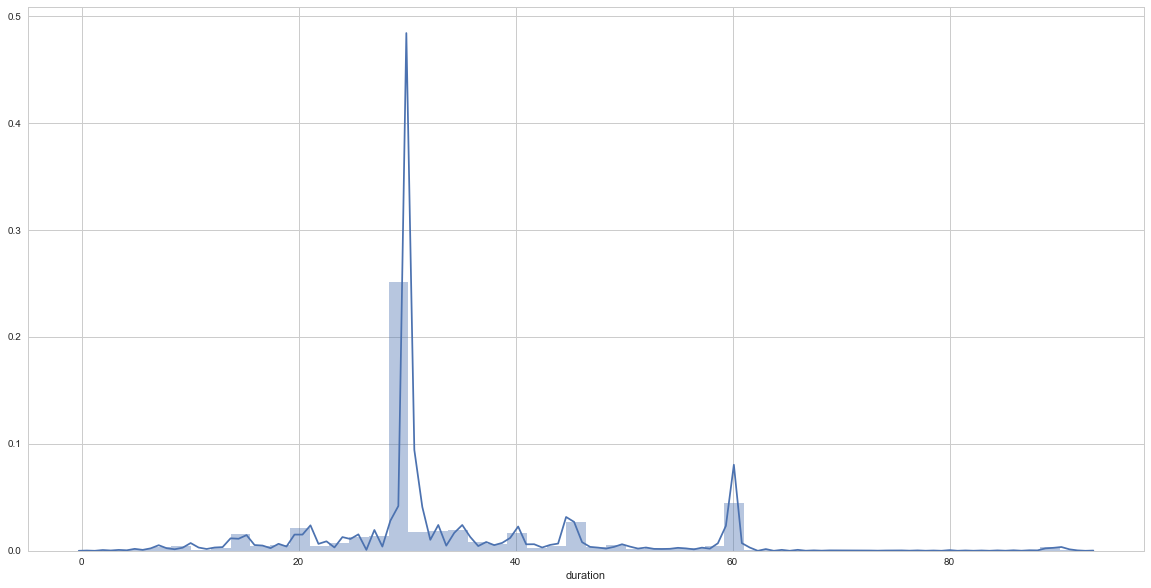

In [23]:
plt.figure(figsize=(20,10))
sns.distplot(df.duration)

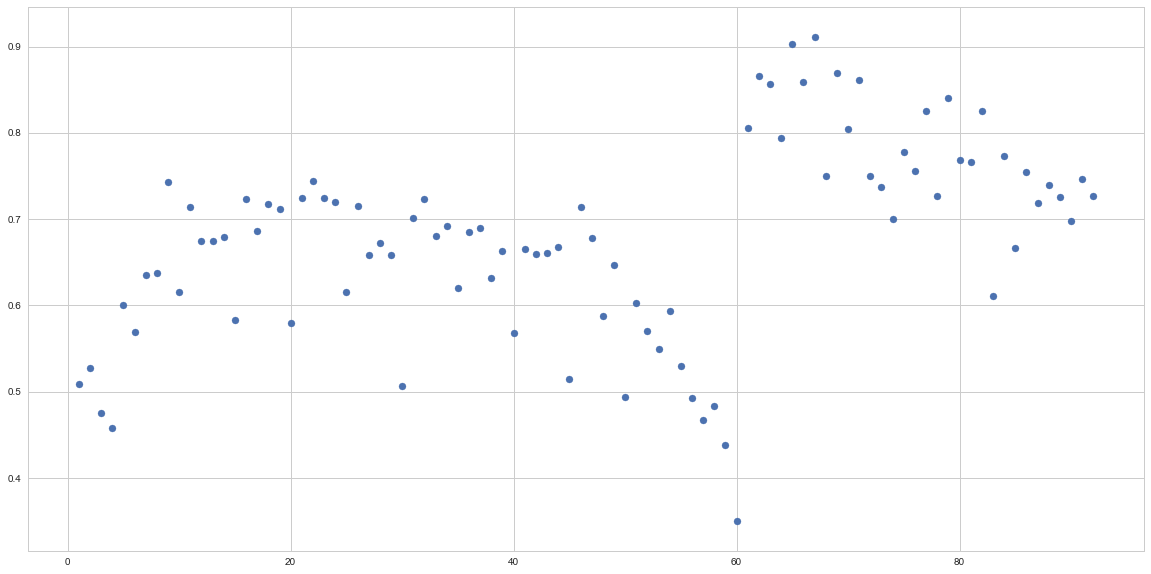

In [24]:
durations=df.groupby(['duration', 'state']).count()['goal']
durations=durations[durations.index.get_level_values('state').isin(['successful', 'failed'])]

plt.figure(figsize=(20,10))
plt.scatter(durations.index.get_level_values('duration').unique(),[list(durations)[i]/(list(durations)[i-1]+list(durations)[i]) for i in range(1,len(list(durations)),2)])

# 4. Preprocessing

In [25]:
state={'state': {'failed': 0,'successful': 1, 'live': 2 }}
df.replace(state, inplace=True)

df['category']=df['category'].astype('category')
df['category']=df['category'].cat.codes

df['subcategory']=df['subcategory'].astype('category')
df['subcategory']=df['subcategory'].cat.codes

df['location']=df['location'].astype('category')
df['location']=df['location'].cat.codes

df['country']=df['country'].astype('category')
df['country']=df['country'].cat.codes

df.disable_communication=df.disable_communication.astype(int)
df.staff_pick=df.staff_pick.astype(int)

In [26]:
df.head()

,backers_count,category,country,disable_communication,goal,staff_pick,state,usd_pledged,location,subcategory,duration
0,80,0,21,0,2800.00,0,1,3596.00,7747,85,22
1,47,0,21,0,3900.00,0,1,4117.00,515,10,23
2,80,0,21,0,750.00,0,1,3125.00,5885,94,19
3,82,0,21,0,4500.00,0,1,4586.00,10966,112,40
4,31,0,21,0,1000.00,0,1,1036.00,8167,94,5


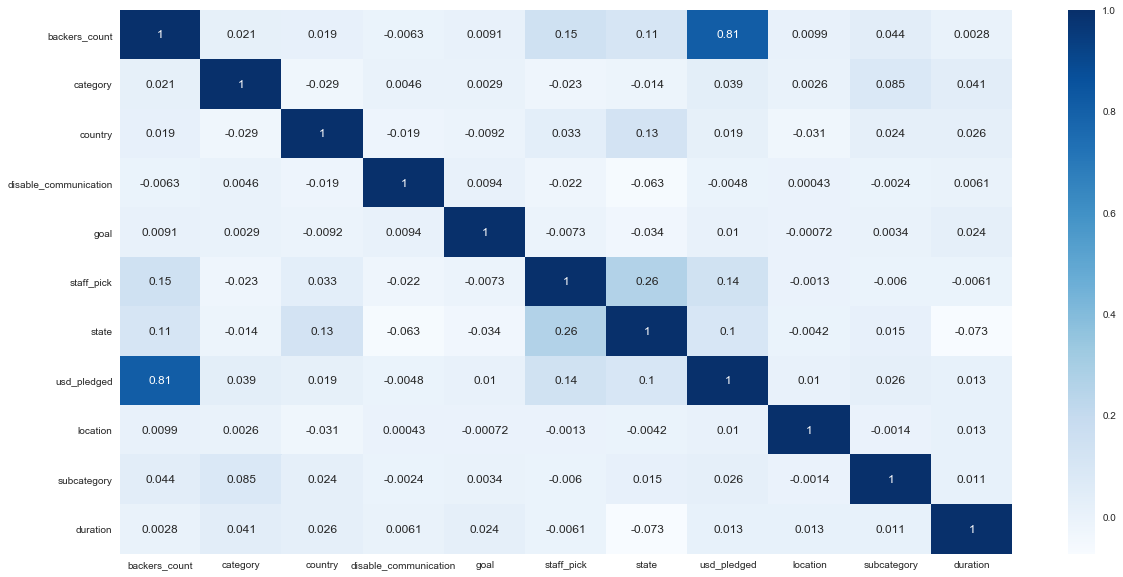

In [27]:
plt.figure(figsize=(20,10))
sns.heatmap(data=df.corr(),annot=True,cmap="Blues")

In [35]:
X=df[['backers_count', 'category', 'country', 'disable_communication', 'goal', 'staff_pick',
        'usd_pledged', 'location','subcategory', 'duration']]
y=df['state']

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

print("X_train Shape: {}".format(X_train.shape))
print("X_test Shape: {}".format(X_test.shape))
print("Y_train Shape: {}".format(y_train.shape))
print("Y_test Shape: {}".format(y_test.shape))

X_train Shape: (138746, 10)
X_test Shape: (46249, 10)
Y_train Shape: (138746,)
Y_test Shape: (46249,)


# 5. Modeling

In [40]:
y_test.mean()

0.5588012713788406

In [37]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
logpred = logreg.predict(X_test)

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
knnpred = knn.predict(X_test)

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
rfcpred = rfc.predict(X_test)

gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
gbcpred = gbc.predict(X_test)

In [38]:
pd.DataFrame(data=[accuracy_score(Y_test, logpred),accuracy_score(Y_test, knnpred),accuracy_score(Y_test, rfcpred),accuracy_score(Y_test, gbcpred)],
             index=['Logistic Regression','KNeighbors Classifier','Random Forest Classifier','Gradient Boosting Classifier', ], columns=['accuracy']).sort_values(by = ['accuracy'], ascending = False)

,accuracy
Random Forest Classifier,0.99
KNeighbors Classifier,0.99
Gradient Boosting Classifier,0.98
Logistic Regression,0.94


In [45]:
print(confusion_matrix(y_test, rfcpred))

[[20140   265]
 [  176 25668]]


In [52]:
from sklearn.model_selection import GridSearchCV

In [124]:
grid=dict(max_depth=list(range(15,20)), n_estimators=list(range(5,10)))
search=GridSearchCV(rfc, grid,scoring='accuracy')
search.fit(X_train,y_train)
search.grid_scores_

C:\Users\olegh\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.99134, std: 0.00020, params: {'max_depth': 15, 'n_estimators': 5},
 mean: 0.99155, std: 0.00012, params: {'max_depth': 15, 'n_estimators': 6},
 mean: 0.99196, std: 0.00018, params: {'max_depth': 15, 'n_estimators': 7},
 mean: 0.99202, std: 0.00021, params: {'max_depth': 15, 'n_estimators': 8},
 mean: 0.99208, std: 0.00008, params: {'max_depth': 15, 'n_estimators': 9},
 mean: 0.99127, std: 0.00013, params: {'max_depth': 16, 'n_estimators': 5},
 mean: 0.99142, std: 0.00012, params: {'max_depth': 16, 'n_estimators': 6},
 mean: 0.99166, std: 0.00029, params: {'max_depth': 16, 'n_estimators': 7},
 mean: 0.99203, std: 0.00011, params: {'max_depth': 16, 'n_estimators': 8},
 mean: 0.99199, std: 0.00034, params: {'max_depth': 16, 'n_estimators': 9},
 mean: 0.99122, std: 0.00020, params: {'max_depth': 17, 'n_estimators': 5},
 mean: 0.99137, std: 0.00018, params: {'max_depth': 17, 'n_estimators': 6},
 mean: 0.99162, std: 0.00040, params: {'max_depth': 17, 'n_estimators': 7},
 mean: 0.991

In [125]:
rfc = RandomForestClassifier(max_depth=20, n_estimators=8, max_features=6, n_jobs=-1, random_state=1)
rfc.fit(X_train, y_train)
rfcpred = rfc.predict(X_test)
accuracy_score(Y_test, rfcpred)

0.9930593093904733

In [126]:
print(confusion_matrix(y_test, rfcpred))

[[20228   177]
 [  144 25700]]
